In [ ]:
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import cycle
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split

In [ ]:
def get_dataset(frequency):
    """
    Load and preprocess a time series dataset for a given frequency.

    Parameters:
    - frequency (str): The frequency of the time series data (e.g., 'hourly', 'daily', 'weekly').

    Returns:
    - dataset (pd.DataFrame): The preprocessed time series dataset.
    """

    train_data = pd.read_csv(f'{frequency}-train.csv').drop(columns='V1')
    test_data = pd.read_csv(f'{frequency}-test.csv').drop(columns='V1')
    # Fill missing values with the mean of its column.
    train_data.fillna(train_data.mean(), inplace=True)
    test_data.fillna(test_data.mean(), inplace=True)
    # Drop rows with NaN values
    train_data = train_data.dropna(how='all')
    test_data = test_data.dropna(how='all')
    # Generate a list of column names as 'T1', 'T2', ..., 'Tn'
    new_column_names = ['T' + str(i + 1) for i in range(len(test_data.columns))]
    # Rename columns in test_data
    test_data.columns = new_column_names
    # Concatenate test_data to train_data
    dataset = pd.concat([train_data, test_data], axis=1)

    return dataset


def detrend_deseason(data):
    """
    Remove trend and seasonality from time series data using linear regression.

    Parameters:
    - data (pd.DataFrame): The input time series data with features as columns.

    Returns:
    - detrended_data (pd.DataFrame): The detrended and deseasoned time series data.
    """

    # Get the list of feature names from the input DataFrame
    feature_names = data.columns.tolist()
    # Iterate through each feature and remove trend and seasonality
    for feature in feature_names:
        # Removing Trend with Ordinary Least Squares (OLS) Regression
        X = sm.add_constant(list(range(data.shape[0])))
        model = sm.OLS(data[feature].values, X)
        result = model.fit()
        fit = pd.Series(result.predict(X), index=data.index)
        data_ols_detrended = data[feature] - fit
        # Removing Seasonality by Differencing
        data_detrended_diff = data_ols_detrended - data_ols_detrended.shift()
        # Update the original data with the detrended and deseasoned values
        data[feature] = data_detrended_diff
    # Drop rows with NaN values
    data = data.dropna(how='all')

    return data


def generate_inputs_and_targets(dataset, window_size, horizon, offset):
    """
    Generate input sequences and target values from a time series dataset.

    Parameters:
    - dataset (pd.DataFrame): The time series dataset.
    - window_size (int): The size of the input window.
    - horizon (int): The prediction horizon (number of timestamps into the future).
    - offset (int): The offset between consecutive input sequences.

    Returns:
    - X_train (np.ndarray): Input sequences for training.
    - y_train (np.ndarray): Target values for training.
    """

    num_series = dataset.shape[0]
    num_timestamps = dataset.shape[1]

    # Initialize lists to store input sequences and target values
    X_train = []
    y_train = []
    for i in range(num_series):
        series = dataset.iloc[i]
        for j in range(0, len(series) - window_size - horizon + 1, offset):
            # Extract input sequence and target values
            input_seq = series[j:j + window_size]
            target_values = series[j + window_size:j + window_size + horizon]
            # Append to the lists
            X_train.append(input_seq)
            y_train.append(target_values)
    # Convert lists to NumPy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train


def split_data(X, y, split_ratio=0.8):
    """
    Split input sequences and target values into training and validation sets.

    Parameters:
    - X (np.ndarray): Input sequences.
    - y (np.ndarray): Target values.
    - split_ratio (float): The ratio of data to be used for training (default is 0.8).

    Returns:
    - X_train (np.ndarray): Input sequences for training.
    - y_train (np.ndarray): Target values for training.
    - X_val (np.ndarray): Input sequences for validation.
    - y_val (np.ndarray): Target values for validation.
    """
    split_index = int(split_ratio * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return X_train, y_train, X_val, y_val


def make_tf_dataset(X, y, batch_size=32):
    """
    Create a TensorFlow dataset from input sequences and target values.

    Parameters:
    - X (np.ndarray): Input sequences.
    - y (np.ndarray): Target values.
    - batch_size (int): Batch size for the TensorFlow dataset (default is 32).

    Returns:
    - tf_dataset (tf.data.Dataset): TensorFlow dataset containing input sequences and target values.
    """
    tf_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)

    return tf_dataset


def build_model(input_shape, output_shape, max_epochs=5):
    """
    Build an MLP (Multilayer Perceptron) model for time series forecasting.

    Parameters:
    - input_shape (int): The number of input units.
    - output_shape (int): The number of output units.
    - max_epochs (int): Maximum number of training epochs (default is 5).

    Returns:
    - model (tf.keras.Model): The constructed MLP model.
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_shape)  # Output layer with 'output_shape' units
    ])

    return model


def compile_and_fit(model, train_data, val_data, max_epochs, patience=2):
    """
    Compile and train a TensorFlow model with early stopping based on validation loss.

    Parameters:
    - model (tf.keras.Model): The TensorFlow model to compile and train.
    - train_data (tf.data.Dataset): Training dataset.
    - val_data (tf.data.Dataset): Validation dataset.
    - max_epochs (int): Maximum number of training epochs.
    - patience (int): Number of epochs with no improvement to wait before early stopping (default is 2).

    Returns:
    - history (tf.keras.callbacks.History): Training history containing loss and metric values.
    """
    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model with early stopping
    history = model.fit(
        train_data,
        epochs=max_epochs,
        validation_data=val_data,
        callbacks=[early_stopping]
    )

    return history


def evaluate_model(model, validation_data):
    """
    Evaluate a trained TensorFlow model using validation data and print the test loss and MAE.

    Parameters:
    - model (tf.keras.Model): The trained TensorFlow model to evaluate.
    - validation_data (tf.data.Dataset): Validation dataset.

    Returns:
    - None
    """
    # Evaluate the model
    test_loss, test_mae = model.evaluate(validation_data)

    # Print evaluation results
    print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')


def plot_predictions(model, y_val, val_dataset, series_index=0):
    """
    Plot the true vs. predicted values for a selected time series using a trained model.

    Parameters:
    - model (tf.keras.Model): The trained TensorFlow model.
    - y_val (np.ndarray): True target values for the validation dataset.
    - val_dataset (tf.data.Dataset): Validation dataset.
    - series_index (int): Index of the time series to plot (default is 0).

    Returns:
    - None
    """
    # Make predictions on the validation dataset
    y_pred = model.predict(val_dataset)

    # Extract the true values and predicted values for the selected time series
    true_values = y_val[:, series_index]
    predicted_values = y_pred[:, series_index]

    # Create timestamps for the x-axis
    timestamps = np.arange(len(true_values))

    # Plot the true vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, true_values, label='True Values', marker='o', markersize=1.5, linestyle='None')
    plt.plot(timestamps, predicted_values, label='Predicted Values', marker='x', markersize=1.5, linestyle='None')
    plt.title('Time Series Forecasting Results')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



def time2vec(dataset, frequency):
    """
    Add one-hot encoded columns for days of the week to a time series dataset.
    Other frequencies are not supported yet.

    Parameters:
    - dataset (pd.DataFrame): The time series dataset to modify.
    - frequency (str): The frequency of the time series data ('Hourly', 'Daily', etc.).

    Returns:
    - dataset (pd.DataFrame): The modified time series dataset with one-hot encoded day columns.
    """
    if frequency == 'Hourly':
        # Define one-hot encodings for days of the week (starting from Monday)
        encodings = [
            [1, 0, 0, 0, 0, 0, 0],  # Monday
            [0, 1, 0, 0, 0, 0, 0],  # Tuesday
            [0, 0, 1, 0, 0, 0, 0],  # Wednesday
            [0, 0, 0, 1, 0, 0, 0],  # Thursday
            [0, 0, 0, 0, 1, 0, 0],  # Friday
            [0, 0, 0, 0, 0, 1, 0],  # Saturday
            [0, 0, 0, 0, 0, 0, 1]   # Sunday
        ]
        encodings_cycle = cycle(encodings)
        new_columns = ['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']

        # Add new columns for one-hot encoding
        for column_name in reversed(new_columns):
            dataset.insert(0, column_name, 0)

        # Replace the new columns' values with the encodings
        for index, row in dataset.iterrows():
            encoding = next(encodings_cycle)
            dataset.loc[index, dataset.columns[:7]] = encoding

    return dataset

Epoch 1/5
9675/9675 [==============================] - 33s 3ms/step - loss: 0.0818 - mae: 0.0549 - val_loss: 0.6802 - val_mae: 0.2835
Epoch 2/5
9675/9675 [==============================] - 25s 3ms/step - loss: 0.0871 - mae: 0.0548 - val_loss: 0.7891 - val_mae: 0.3026
Epoch 3/5
2419/2419 [==============================] - 22s 9ms/step - loss: 0.7611 - mae: 0.2965
Test Loss: 0.7610944509506226, Test MAE: 0.2964736223220825
2419/2419 [==============================] - 4s 1ms/step


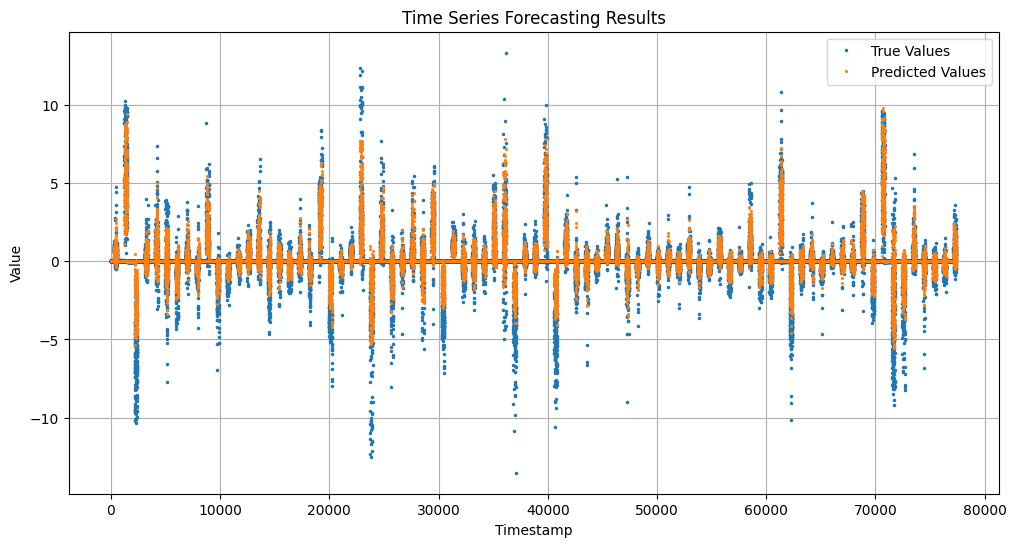

In [8]:
HORIZON = {
    # Output width of MLP (specified by m4 competition)
    'Yearly': 6,
    'Quarterly': 8,
    'Monthly': 18,
    'Daily': 14,
    'Hourly': 48
}
CONV_WIDTH = {
    # Input width of MLP (adjust as needed. Taking seasonality into
    # account could be a good approach.)
    'Yearly': 6,
    'Quarterly': 8,
    'Monthly': 18,
    'Daily': 14,
    'Hourly': 24
}


# params
scaler = StandardScaler()       # change to MinMaxScaler if you want
frequency = 'Hourly'            # choose which timeseries to load
offset = 1                      # offset between input window and horizon
max_epochs = 5                  # max epochs of MLP during training



# In the following code, the name of the functions are
# self-explanatory as to what is going on in each step.



dataset = get_dataset(frequency)
if not frequency == 'Yearly':
    # We assume that yearly timeseries
    # do not inherit significant trend
    # or seasonality to bother with.
    dataset = detrend_deseason(dataset)
    pass
X_train = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)  # scale data
X_train, y_train = generate_inputs_and_targets(dataset=X_train,
                                                window_size=CONV_WIDTH[frequency],
                                                horizon=HORIZON[frequency],
                                                offset=offset)
X_train, y_train, X_val, y_val = split_data(X=X_train, y=y_train)
tf_train = make_tf_dataset(X=X_train, y=y_train)  # tf = tensorflow
tf_val = make_tf_dataset(X=X_val, y=y_val)
model = build_model(input_shape=CONV_WIDTH[frequency],
                        output_shape=HORIZON[frequency],
                        max_epochs=3)
history = compile_and_fit(model=model,
                            train_data=tf_train,
                            val_data=tf_val,
                            max_epochs=max_epochs,
                            patience=2)
_ = evaluate_model(model=model, validation_data=tf_val)
_ = plot_predictions(series_index=0, model=model, y_val=y_val, val_dataset=tf_val)

